# <font color="#F48E16">Formación en XAI de Deep Learning: Coeficiente de Explicabilidad Rendimiento</font>

Material generado por <a href="https://www.linkedin.com/in/christian-oliva-moya-ingeniero/">Christian Oliva</a>. Cualquier duda, sugerencia o errata, no duden en contactar.

**Versión 1.0** - 29 de agosto de 2025

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import kagglehub
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

## <font color="#F48E16">Datos</font>

En este notebook se muestra la implementación manual de los diferentes algoritmos de explicabilidad genérica vistos durante el curso, que son los siguientes:

- Importancia por permutación

- Relevancia por oclusión

- SHAP

- LIME

Para ello, se van a utilizar diferentes modelos sencillos de SKLearn sobre un dataset de riesgo financiero para la aprobación de préstamos: **Loan Approval Classification Dataset**

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

<hr>

En el notebook se desarrolla el código por completo según una fase sencilla de preprocesamiento de los datos, el entrenamiento de algunos modelos y la explicabilidad utilizando los diferentes algoritmos.

### Descarga de datos de Kaggle

In [2]:
# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-approval-classification-data


In [3]:
data = pd.read_csv(path + "/loan_data.csv")
data

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


In [4]:
data["person_age"] = np.log(np.clip(data["person_age"], 0, 70))
data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
data["person_income"] = np.log(data["person_income"])
data["person_emp_exp"] = np.log(data["person_emp_exp"]+1)
data = pd.concat((data, pd.get_dummies(data["person_home_ownership"], prefix="person_home_ownership_")), axis=1)
data = data.drop(columns=["person_home_ownership"])
data["loan_amnt"] = np.log(data["loan_amnt"])
data = pd.concat((data, pd.get_dummies(data["loan_intent"], prefix="loan_intent_")), axis=1)
data = data.drop(columns=["loan_intent"])
data["loan_percent_income"] = np.log(data["loan_percent_income"]+0.1)
data["cb_person_cred_hist_length"] = np.log(data["cb_person_cred_hist_length"])
data["previous_loan_defaults_on_file"] = data["previous_loan_defaults_on_file"].replace({"No": 0, "Yes": 1})

/tmp/ipython-input-2525706371.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_gender"] = data["person_gender"].replace({"female":0, "male":1})
/tmp/ipython-input-2525706371.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["person_education"] = data["person_education"].replace({"High School":0, "Associate":1, "Bachelor":2, "Master":3, "Doctorate":4})
/tmp/ipython-input-2525706371.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old 

### Separación en TRAIN-TEST y normalización

In [5]:
X = data.drop(columns=["loan_status"])
y = data["loan_status"]

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
means = X_train_raw.mean()
stds = X_train_raw.std()
X_train = (X_train_raw-means) / stds
X_test = (X_test_raw-means) / stds

In [8]:
X_train.describe()

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,person_home_ownership__MORTGAGE,person_home_ownership__OTHER,person_home_ownership__OWN,person_home_ownership__RENT,loan_intent__DEBTCONSOLIDATION,loan_intent__EDUCATION,loan_intent__HOMEIMPROVEMENT,loan_intent__MEDICAL,loan_intent__PERSONAL,loan_intent__VENTURE
count,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,...,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04,3.600000e+04
mean,-2.044587e-15,-8.092292e-18,3.088887e-17,-1.318254e-15,-4.144833e-18,-1.299504e-15,1.139681e-15,1.340163e-16,-2.197748e-16,-6.506400e-16,...,-8.990339e-17,1.973730e-19,7.065953e-17,1.028313e-16,6.710681e-17,1.302662e-17,2.171103e-17,5.279727e-18,-2.072416e-17,6.118562e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.634282e+00,-1.106582e+00,-1.288573e+00,-3.820060e+00,-1.480771e+00,-3.838885e+00,-1.867012e+00,-2.348392e+00,-1.469157e+00,-4.827681e+00,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
25%,-6.664523e-01,-1.106582e+00,-1.288573e+00,-6.451277e-01,-7.631502e-01,-5.969609e-01,-8.101133e-01,-8.153795e-01,-7.966108e-01,-6.094639e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,-1.041224e+00,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
50%,-2.415560e-01,9.036589e-01,-3.606891e-01,-1.742892e-02,1.854926e-01,6.478053e-02,2.628404e-03,-7.049805e-02,-3.194316e-01,1.466317e-01,...,-8.352804e-01,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
75%,5.180761e-01,9.036589e-01,5.671948e-01,6.186931e-01,7.940326e-01,6.646859e-01,6.782409e-01,7.276121e-01,8.302939e-01,7.435493e-01,...,1.197169e+00,-5.251197e-02,-2.660026e-01,9.603814e-01,-4.351211e-01,-5.078370e-01,-3.441812e-01,-4.833536e-01,-4.485483e-01,-4.573220e-01
max,5.015846e+00,9.036589e-01,2.422962e+00,8.343544e+00,3.526269e+00,2.142782e+00,3.009438e+00,3.394679e+00,3.022695e+00,4.325055e+00,...,1.197169e+00,1.904275e+01,3.759257e+00,9.603814e-01,2.298147e+00,1.969081e+00,2.905366e+00,2.068821e+00,2.229352e+00,2.186582e+00


In [9]:
columnas = X_train_raw.columns
columnas

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'person_home_ownership__MORTGAGE',
       'person_home_ownership__OTHER', 'person_home_ownership__OWN',
       'person_home_ownership__RENT', 'loan_intent__DEBTCONSOLIDATION',
       'loan_intent__EDUCATION', 'loan_intent__HOMEIMPROVEMENT',
       'loan_intent__MEDICAL', 'loan_intent__PERSONAL',
       'loan_intent__VENTURE'],
      dtype='object')

In [10]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [11]:
X_train.shape, y_train.shape

((36000, 21), (36000,))

## <font color="#F48E16">Modelos</font>

### Regresión Logística (modelo lineal)

In [12]:
rl = LogisticRegression()
rl.fit(X_train, y_train)
pred = rl.predict(X_test)
rl.score(X_test, y_test)

0.8952222222222223

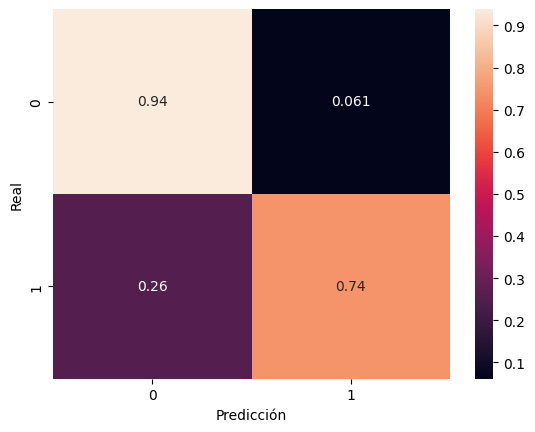

In [14]:
sns.heatmap(confusion_matrix(y_test, pred, normalize="true"), annot=True)
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel().tolist()

print(" > ACCURACY:", (tp+tn)/(tp+tn+fp+fn))
print(" > PRECISION:", tp/(tp+fp))
print(" > RECALL:", tp/(tp+fn))

 > ACCURACY: 0.8952222222222223
 > PRECISION: 0.7771428571428571
 > RECALL: 0.7442786069651741


### MLP

In [16]:
red = MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000)
red.fit(X_train, y_train)
pred = red.predict(X_test)
red.score(X_test, y_test)

0.9177777777777778

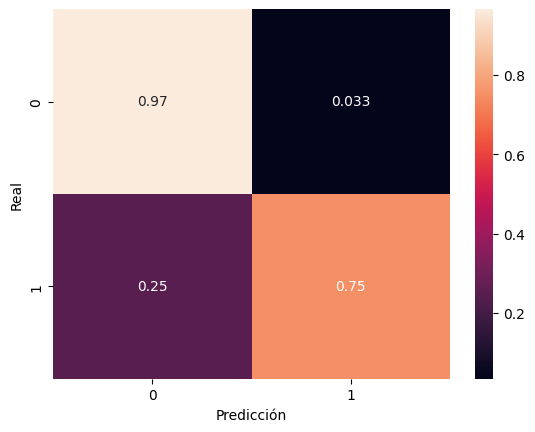

In [17]:
sns.heatmap(confusion_matrix(y_test, pred, normalize="true"), annot=True)
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel().tolist()

print(" > ACCURACY:", (tp+tn)/(tp+tn+fp+fn))
print(" > PRECISION:", tp/(tp+fp))
print(" > RECALL:", tp/(tp+fn))

 > ACCURACY: 0.9177777777777778
 > PRECISION: 0.8653624856156502
 > RECALL: 0.7482587064676617


## <font color="#F48E16">Explicabilidad</font>

**IMPORTANTE**: Por simplicidad para los algoritmos más pesados, vamos a utilizar solo un trocito de X_train como si fuese nuestro dataset completo.

In [19]:
X_train_small = X_train[:100]
y_train_small = y_train[:100]

### Importancia por permutación [Método global]

La importancia por permutación consiste en permutar uno a uno los atributos del dataset de entrada y evaluar el modelo M para ver cómo se modifica su rendimiento. La relevancia, por tanto, se define así:

$$R_i = M(X) - \frac{1}{N} \sum_{j=1}^N M(X'_i)$$

donde $R_i$ es la relevancia del atributo $i$-ésimo, $M(X)$ representa la métrica de rendimiento del modelo $M$ a partir del dataset original $X$, $N$ es el número de repeticiones para promediar, y $X'_i$ hace referencia al dataset original X habiendo permutado el atributo $i$-ésimo.

**¿Por qué se hace esto?**

Porque si se pierde rendimiento cuando se rompe el atributo $i$-ésimo, esto significa que dicho atributo es importante para el modelo.

Este algoritmo de explicabilidad es un método global, ya que utiliza todo el dataset para dar un valor global de la relevancia de un atributo.

In [20]:
def importancia_permutacion(X, y, model, N=10):
    Rx = np.zeros(X.shape[1])
    for i in tqdm(range(X.shape[1])):
        for j in range(N):
            X_perm = X.copy()
            np.random.shuffle(X_perm[:, i])
            Rx[i] += model.score(X_perm, y)
    Rx = model.score(X, y) - Rx / N
    return Rx

In [21]:
Rx_perm_rl = importancia_permutacion(X_train, y_train, rl, N=10)
Rx_perm_red = importancia_permutacion(X_train, y_train, red, N=10)

100%|██████████| 21/21 [00:08<00:00,  2.57it/s]


### Relevancia por oclusión [Método local y global]

La relevancia por oclusión, en general, se utiliza como técnica de explicabilidad de modelos que procesan imágenes, pero, aunque es una técnica que veremos más adelante aplicada a dicha tarea, también puede ser utilizada en problemas tabulares. La relevancia por oclusión es un método híbrido, que puede ser aplicado de forma tanto local (para una observación concreta) como global (para todo el dataset), que consiste en anular una región del espacio de atributos de entrada.

El término anular consiste en reemplazar un atributo $i$-ésimo por un valor "inteligente", por ejemplo:

- Un valor fijo 0

- La media del atributo

- La moda del atributo

- Un valor imputado mediante un algoritmo más complejo

La relevancia por oclusión global para datos tabulares se calcula, entonces, de la siguiente manera:

$$R_i = M(X) - M(X'_i)$$

donde $M(X)$ representa una métrica de rendimiento del modelo $M$ al procesar el dataset $X$ y $M(X'_i)$ representa la misma métrica de rendimiento al procesar el dataset con el atributo $i$-ésimo anulado.

Sin embargo, si se busca la oclusión a nivel local, se calcularía de la siguiente manera:

$$R_i(x) = f(x) - f(x'_i)$$

donde $f(x)$ es la predicción del modelo para el dato de entrada $x$ y $f(x'_i)$ es la predicción del mismo modelo para el dato de entrada $x$ con el atributo $i$-ésimo anulado.

**¿Por qué se sigue esta estrategia?**

Esta estrategia se basa en una idea parecida a la importancia por permutación, donde se evalúa el modelo después de modificar un atributo de entrada del dataset.

En el siguiente código se va a utilizar el valor fijo 0 porque es la media de los atributos de entrada, ya que están normalizados.

In [32]:
def relevancia_oclusion(X, y, model, verbose=True):
  if X.ndim == 1: # 1 solo dato, lo ponemos en formato matricial
    X = X[None, :]
    pred = model.predict_proba(X)
  else:
    score = model.score(X, y)

  num_atributos = X.shape[-1]

  iterador_num_atributos = tqdm(range(num_atributos)) if verbose else range(num_atributos)
  Rx = np.zeros(num_atributos)
  for i in iterador_num_atributos:
    X_null = X.copy()
    X_null[:, i] = 0
    if X.shape[0] == 1: # solo un dato, relevancia local
      Rx[i] = pred[0,y] - model.predict_proba(X_null)[0,y]
    else: # más de un dato, relevancia global
      Rx[i] = score - model.score(X_null, y)
  return Rx

**Relevancia global**

In [33]:
Rx_oclu_rl = relevancia_oclusion(X_train, y_train, rl)
Rx_oclu_red = relevancia_oclusion(X_train, y_train, red)

100%|██████████| 21/21 [00:00<00:00, 35.59it/s]


**Relevancia local**

Ahora vamos a explicar un dato particular.

In [34]:
item = 0

In [35]:
Rx_oclu_local_rl = relevancia_oclusion(X_train_small[item], y_train_small[item], rl)
Rx_oclu_local_red = relevancia_oclusion(X_train_small[item], y_train_small[item], red)

100%|██████████| 21/21 [00:00<00:00, 2741.20it/s]


### SHAP (SHapley Additive exPlanations)

El valor de Shapley en teoría de juegos para una característica $i$-ésima es el siguiente:

$$\phi_i(x) = \sum_{S\subseteq F\setminus \{i\}} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \{i\}}(x) - f_S(x)]$$

donde $F$ es el conjunto de todos los atributos (features) y $f_S(x)$ es la predicción del modelo cuando sólo usamos los atributos de $S$, imputando el resto. Es decir, hay que calcular todas las permutaciones posibles de todos los atributos con todos los atributos excepto el $i$-ésimo. Como esto es exponencial y no es viable, lo que se hace en la práctica es **muestrear permutaciones aleatorias de atributos**.

¿En qué consiste la idea? En ir introduciendo de forma aleatoria atributos a la instancia del dataset, imputando el resto de atributos (con la media por ejemplo) y evaluando cómo afecta incorporar ese atributo a la decisión del modelo. Podemos basarnos en esta idea:

$$contribución_i = f_{S\cup \{i\}}(x) - f_S(x)$$

SHAP es, por tanto, un método de explicabilidad local que utiliza la imputación conforme al total de los datos para explicar una instancia particular del dataset.

In [41]:
def shap(X, y, model, item, N=10, verbose=True):
    num_atributos = X.shape[1]
    shap_values = np.zeros(num_atributos)
    x = X[item][None, :]
    y = y[item]

    baseline = model.predict_proba(X).mean(axis=0, keepdims=True)

    iterador_N = tqdm(range(N)) if verbose else range(N)
    for _ in iterador_N:
      prev_pred = baseline
      perm = np.random.permutation(num_atributos)
      for c, i in enumerate(perm):
        x_S = x.copy()
        x_S[:, perm[c+1:]] = X.mean(axis=0)[perm[c+1:]] # Esta estrategia puede ser diferente
        pred = model.predict_proba(x_S)
        shap_values[i] += (pred - prev_pred)[0,y]
        prev_pred = pred

    return shap_values / N

In [42]:
Rx_shap_rl = shap(X_train_small, y_train_small, rl, item=0, N=50)
Rx_shap_red = shap(X_train_small, y_train_small, red, item=0, N=50)

100%|██████████| 50/50 [00:00<00:00, 236.77it/s]


### LIME (Local Interpretable Model-agnostic Explanations)

LIME es un algoritmo de explicabilidad local basado en la idea de aproximar el comportamiento del modelo complejo con puntos cercanos a la instancia que se quiere explicar utilizando un modelo lineal.

¿Cómo funciona la idea?

1. Generamos un dataset sintético $X'$ alrededor de la instancia $x$.
2. Se calculan las predicciones del modelo complejo sobre $X'$.
3. Se asignan pesos a los puntos de $X'$ según su cercanía a la instancia $x$.
4. Se entrena un modelo lineal con los puntos de $X'$ según la cercanía.

Así, el modelo lineal aprende cómo cambian las predicciones alrededor de $x$. Además, **los pesos del modelo lineal son los valores de relevancia de cada atributo**.

LIME, al contrario que SHAP, no hace combinaciones exhaustivas, sino que solo mira el vecindario cercano a la instancia $x$.

In [43]:
def lime(X, y, model, item, D=1000):
  num_atributos = X.shape[1]
  x0 = X[item][None, :]
  y = y[item]

  # 1. Generamos dataset sintetico X_perturbed alrededor de x0
  X_perturbed = np.repeat(x0, D, axis=0)
  noise = np.random.normal(size=X_perturbed.shape) * X.std(axis=0, keepdims=True)
  X_perturbed += noise

  # 2. Se calculan las predicciones del modelo sobre X_perturbed
  y_perturbed = model.predict_proba(X_perturbed)[:, y]

  # 3. Se asignan pesos a los puntos de X_perturbed según la distancia a x0
  distances = np.linalg.norm(X_perturbed - x0, axis=1) + 1e-8
  weights = 1 / distances # más distancia, menor peso. Esta estrategia puede ser diferente

  # 4. Se entrena un modelo lineal con los puntos de X_perturbed
  linear_model = LinearRegression()
  linear_model.fit(X_perturbed, y_perturbed, sample_weight=weights) # NO OLVIDAR sample_weights
  Rx = linear_model.coef_

  return Rx

In [45]:
Rx_lime_rl = lime(X_train_small, y_train_small, rl, 0)
Rx_lime_red = lime(X_train_small, y_train_small, red, 0)

## <font color="#F48E16">Coeficiente de Explicabilidad-Rendimiento</font>

El Coeficiente de Explicabilidad-Rendimiento, propuesto en la tesis del autor, consiste en realizar dos pruebas concretas sobre las que construir una métrica:

Dada la explicabilidad de un modelo *M* o, en otras palabras, la relevancia de los atributos de entrada *R* para ese modelo *M* y una métrica de evaluación *m* de *M*, como puede ser el porcentaje de acierto (*accuracy*) en un problema de clasificación, o el coeficiente de determinación R2 en un problema de regresión, si se define un umbral *U* que divide *R* en atributos relevantes (*R > U*) y no relevantes (*R < U*), se proponen dos pruebas:

- **Prueba 1**: Anulando para todos los patrones de entrada los atributos que quedan por debajo del umbral según *R < U*, se puede volver a evaluar el modelo *M* y calcular la métrica $m^+$ sobre el conjunto de atributos relevantes supervivientes.

- **Prueba 2**: Anulando para todos los patrones de entrada los atributos que quedan por encima del umbral según *R > U*, se puede volver a evaluar el modelo *M* y calcular la métrica $m^-$ sobre el conjunto de atributos no relevantes supervivientes.

Con estas pruebas, se sigue la siguiente hipótesis:

**Si se selecciona el conjunto de atributos más relevantes $ar$ del total de atributos $at$ y el resto se anulan, el rendimiento del modelo $m^+$ no debe verse afectado de manera significativa y, en el caso contrario, el rendimiento del modelo $m^-$ debe reducirse considerablemente.**

Siguiendo esta hipótesis, se propone el Coeficiente de Explicabilidad Rendimiento como:

$$EPC(M|R,U) = \frac{at-ar}{at} \times \frac{m^+ - m^-}{m}$$

El EPC mide el equilibrio entre el porcentaje de atributos considerados como relevantes frente al rendimiento del modelo. Maximizar el EPC consistirá en identificar y eliminar atributos no relevantes sin disminuir el rendimiento del modelo.

**Hay que diferenciar si la explicabilidad es global o local**

- Si la explicabilidad es global, hay un único valor de $R_i$ para cada atributo, por lo que se anulan todos los atributos del dataset según el único umbral $R_i$.

- Si la explicabilidad es local, hay un valor de $R_{ij}$ para cada atributo e instancia del dataset, por lo que, para cada instancia del dataset, hay que definir un umbral $U_{ij}$ para cada atributo.

In [94]:
def epc(X, y, model, Rx, local=False):
  at = Rx.shape[-1]
  m = model.score(X, y)
  epc_all = []
  if not local: # Si es global
    for i in range(at):
        ar = at - i
        factor1 = (at - ar) / at

        umbral = np.sort(Rx[0])[i] # Usamos el mismo umbral para todo el dataset

        # Prueba 1
        X_prueba1 = X.copy()
        X_prueba1[Rx <= umbral] = 0
        mmas = model.score(X_prueba1, y)

        # Prueba 2
        X_prueba2 = X.copy()
        X_prueba2[Rx >= umbral] = 0
        mmenos = model.score(X_prueba2, y)

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)

  else: # Si es local
    for i in range(at):
        ar = at - i
        factor1 = (at - ar) / at

        # Prueba 1
        X_prueba1 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Por cada instancia x hay una relevancia r
            umbral = np.sort(r)[i] # y tenemos que usar esa r para definir el umbral
            X_prueba1[j, r <= umbral] = 0
        mmas = model.score(X_prueba1, y)

        # Prueba 2
        X_prueba2 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Lo mismo aquí con la prueba 2
            umbral = np.sort(r)[i]
            X_prueba2[j, r >= umbral] = 0
        mmenos = model.score(X_prueba2, y)

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)

  return np.array(epc_all)

### Cuando la explicabilidad es global

In [95]:
epc_perm_rl = epc(X_train, y_train, rl, np.repeat(Rx_perm_rl[None, :], X_train.shape[0], axis=0))
epc_oclu_rl = epc(X_train, y_train, rl, np.repeat(Rx_oclu_rl[None, :], X_train.shape[0], axis=0))
epc_perm_red = epc(X_train, y_train, red, np.repeat(Rx_perm_red[None, :], X_train.shape[0], axis=0))
epc_oclu_red = epc(X_train, y_train, red, np.repeat(Rx_oclu_red[None, :], X_train.shape[0], axis=0))

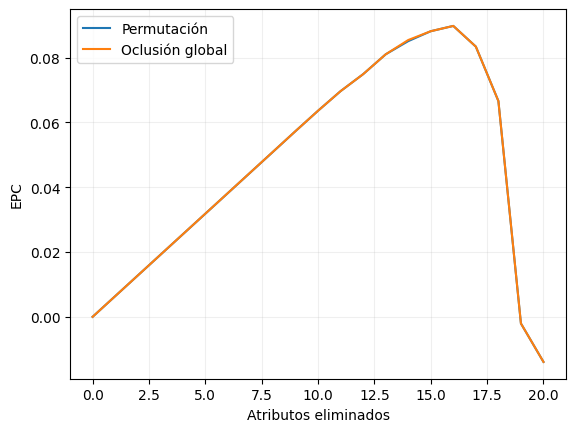

In [96]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

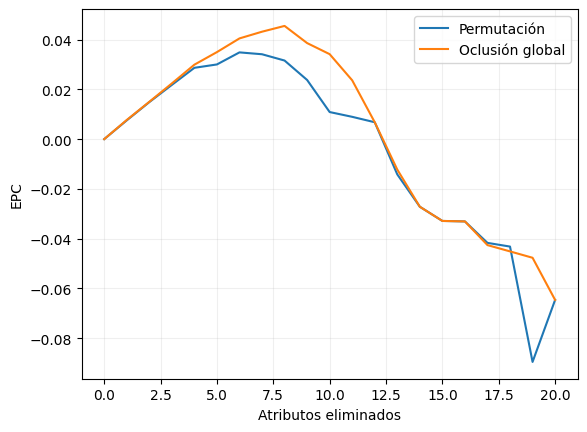

In [97]:
plt.plot(epc_perm_red, label="Permutación")
plt.plot(epc_oclu_red, label="Oclusión global")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

### Cuando la explicabilidad es local

Necesitamos calcular la relevancia de cada instancia del dataset. Por eso utilizamos `X_train_small` con solo 100 datos, para no tardar mucho.

In [88]:
Rx_oclu_local_rl = np.array([relevancia_oclusion(X_train_small[item], y_train_small[item], rl, verbose=False) for item in range(len(X_train_small))])
Rx_oclu_local_red = np.array([relevancia_oclusion(X_train_small[item], y_train_small[item], red, verbose=False) for item in range(len(X_train_small))])

In [89]:
Rx_shap_rl = np.array([shap(X_train_small, y_train_small, rl, item, N=50, verbose=False) for item in range(len(X_train_small))])
Rx_shap_red = np.array([shap(X_train_small, y_train_small, red, item, N=50, verbose=False) for item in range(len(X_train_small))])

In [90]:
Rx_lime_rl = np.array([lime(X_train_small, y_train_small, rl, item) for item in range(len(X_train_small))])
Rx_lime_red = np.array([lime(X_train_small, y_train_small, red, item) for item in range(len(X_train_small))])

**Observación**: El EPC se basa en anular atributos, por lo que tenemos que modificar LIME para que nos indique el comportamiento correcto.

In [98]:
epc_oclu_local_rl = epc(X_train_small, y_train_small, rl, Rx_oclu_local_rl, local=True)
epc_oclu_local_red = epc(X_train_small, y_train_small, red, Rx_oclu_local_red, local=True)
epc_shap_rl = epc(X_train_small, y_train_small, rl, Rx_shap_rl, local=True)
epc_shap_red = epc(X_train_small, y_train_small, red, Rx_shap_red, local=True)
epc_lime_rl = epc(X_train_small, y_train_small, rl, (Rx_lime_rl*np.sign(X_train_small)), local=True) # Tenemos que multiplicar aquí por el signo de x
epc_lime_red = epc(X_train_small, y_train_small, red, (Rx_lime_red*np.sign(X_train_small)), local=True) # Aquí igual

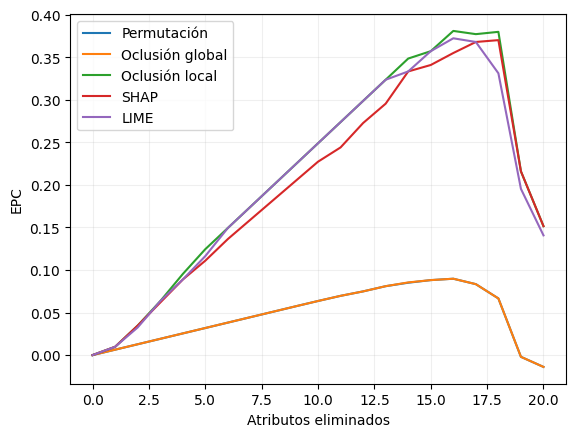

In [99]:
plt.plot(epc_perm_rl, label="Permutación")
plt.plot(epc_oclu_rl, label="Oclusión global")
plt.plot(epc_oclu_local_rl, label="Oclusión local")
plt.plot(epc_shap_rl, label="SHAP")
plt.plot(epc_lime_rl, label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

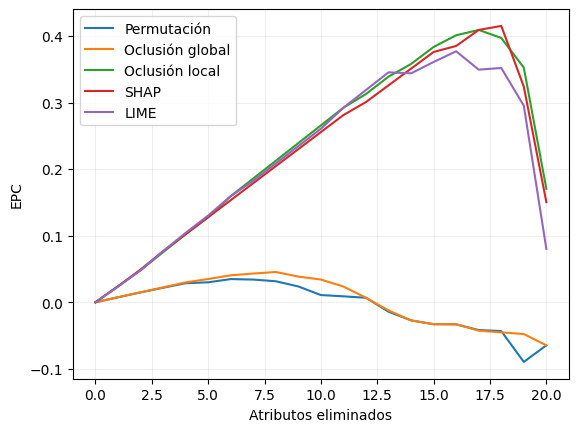

In [100]:
plt.plot(epc_perm_red, label="Permutación")
plt.plot(epc_oclu_red, label="Oclusión global")
plt.plot(epc_oclu_local_red, label="Oclusión local")
plt.plot(epc_shap_red, label="SHAP")
plt.plot(epc_lime_red, label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)

**¿Conclusiones? ¿Dudas?**

- El EPC nos permite evaluar cuántos atributos puedo eliminar sin perder rendimiento (o con una pérdida de rendimiento razonable).

- El EPC de los algoritmos locales es mayor que el de los algoritmos globales. Tiene sentido por la especificidad al dato de entrada en lugar de al global de los datos.

- Aparentemente, los tres algoritmos de explicabilidad local tienen un rendimiento similar.

<hr>

Permitidme modificar el código del EPC para devolver también el $m^+$.

In [102]:
def epc_all_data(X, y, model, Rx, local=False):
  at = Rx.shape[-1]
  m = model.score(X, y)
  epc_all = []
  mmas_all = []
  if not local: # Si es global
    for i in range(at):
        ar = at - i
        factor1 = (at - ar) / at

        umbral = np.sort(Rx[0])[i] # Usamos el mismo umbral para todo el dataset

        # Prueba 1
        X_prueba1 = X.copy()
        X_prueba1[Rx <= umbral] = 0
        mmas = model.score(X_prueba1, y)

        # Prueba 2
        X_prueba2 = X.copy()
        X_prueba2[Rx >= umbral] = 0
        mmenos = model.score(X_prueba2, y)

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)
        mmas_all.append(mmas)

  else: # Si es local
    for i in range(at):
        ar = at - i
        factor1 = (at - ar) / at

        # Prueba 1
        X_prueba1 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Por cada instancia x hay una relevancia r
            umbral = np.sort(r)[i] # y tenemos que usar esa r para definir el umbral
            X_prueba1[j, r <= umbral] = 0
        mmas = model.score(X_prueba1, y)

        # Prueba 2
        X_prueba2 = X.copy()
        for j, (x, r) in enumerate(zip(X, Rx)): # Lo mismo aquí con la prueba 2
            umbral = np.sort(r)[i]
            X_prueba2[j, r >= umbral] = 0
        mmenos = model.score(X_prueba2, y)

        factor2 = (mmas - mmenos) / m

        epc = factor1 * factor2
        epc_all.append(epc)
        mmas_all.append(mmas)

  return np.array(epc_all), np.array(mmas_all)

In [103]:
epc_oclu_local_rl, mmas_oclu_local_rl = epc_all_data(X_train_small, y_train_small, rl, Rx_oclu_local_rl, local=True)
epc_oclu_local_red, mmas_oclu_local_red = epc_all_data(X_train_small, y_train_small, red, Rx_oclu_local_red, local=True)
epc_shap_rl, mmas_shap_rl = epc_all_data(X_train_small, y_train_small, rl, Rx_shap_rl, local=True)
epc_shap_red, mmas_shap_red = epc_all_data(X_train_small, y_train_small, red, Rx_shap_red, local=True)
epc_lime_rl, mmas_lime_rl = epc_all_data(X_train_small, y_train_small, rl, (Rx_lime_rl*np.sign(X_train_small)), local=True) # Tenemos que multiplicar aquí por el signo de x
epc_lime_red, mmas_lime_red = epc_all_data(X_train_small, y_train_small, red, (Rx_lime_red*np.sign(X_train_small)), local=True) # Aquí igual

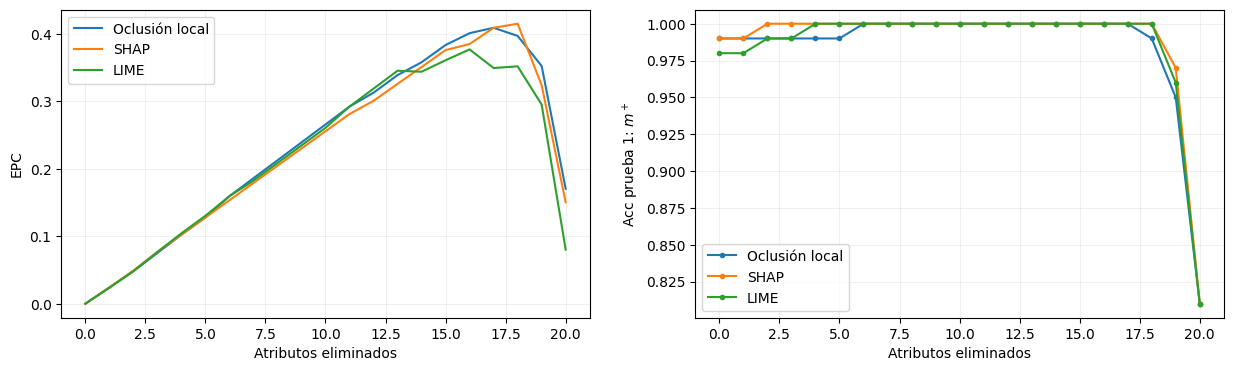

In [114]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(epc_oclu_local_red, label="Oclusión local")
plt.plot(epc_shap_red, label="SHAP")
plt.plot(epc_lime_red, label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("EPC")
plt.grid(alpha=0.2)
plt.subplot(1,2,2)
plt.plot(mmas_oclu_local_red, '.-', label="Oclusión local")
plt.plot(mmas_shap_red, '.-', label="SHAP")
plt.plot(mmas_lime_red, '.-', label="LIME")
plt.xlabel("Atributos eliminados")
plt.legend()
plt.ylabel("Acc prueba 1: $m^+$")
plt.grid(alpha=0.2)
plt.show()

**¿Qué está sucediendo?**

- El accuracy de la prueba 1 $m^+$ está subiendo al 100%. ¿Por qué? ¿Es correcto?

**Decisión personal**

- Visto lo visto, yo me quedaría por ahora con la oclusión local por ser más suave la curva (gusto personal). El que parece que es un poco peor es LIME según el EPC.